In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import seaborn_image as isns

import torch
from torch import nn
from tltorch.factorized_tensors.core import FactorizedTensor

from config import Environment
from denoising.data.utils import load_grayscale

isns.set_context('notebook')  # this will create thicker lines and larger fonts than usual
isns.set_image(cmap='gray', despine=True)  # set the colormap and despine the axes

In [5]:
# загружаем переменные окружения
env = Environment(_env_file='../env')

In [17]:
image = torch.Tensor(load_grayscale(env.data / 'lena.png') / 255.0).unsqueeze(0)

fft = torch.fft.rfftn(image, norm='forward', dim=dims)

torch.Size([1, 512, 512])


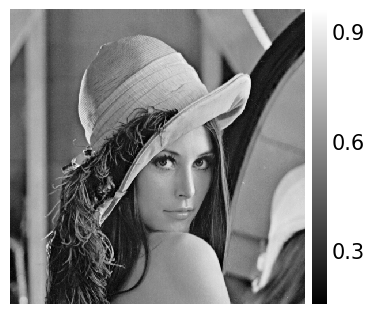

In [18]:
_ = isns.ImageGrid(
    [
        image[0, ...].numpy(),
    ],
    height=4,
)